# Trace Analysis of LMS IP

A Custom overlay was used with two trace analyzers: one to measure input Y and the other to measure output YHat.

For a more comprehensive demonstration of the IP, see the `LMS` notebook.

In [24]:
from pynq.overlays.logictools.logictools_axis_int import LogicToolsOverlay
from pynq.lib.logictools.compute import axistream_int
from pynq.lib.logictools.wavedrom_print import axistream_print
from pynq import Overlay
import numpy as np
import time
import pynq.lib.dma
import random
from pynq import allocate
import random
import math

In [38]:
# Identity is just a scaling factor used to treat integers
# Like fixed point numbers because natively Pynq only supports
# int types over axi streaming
IDENTITY = pow(2,14)
test_ir = np.array([
-0.058158606314549964,
-0.11179499610251085,
-0.06955371490925417,
0.1277783378304197,
0.38326899688464383,
0.5020701199449168,
0.38326899688464383,
0.1277783378304197,
-0.06955371490925417,
-0.11179499610251085,
-0.058158606314549964,
])

n = 100

L = len(test_ir)
SNR = 1000
SeqLen = n - L + 1
x = allocate(shape=n, dtype=np.int32)
y = allocate(shape=SeqLen, dtype=np.int32)
yhat = allocate(shape=n, dtype=np.int32)

x_np = np.random.normal(0, 0.01, SeqLen+L-1)
y_np = np.zeros(SeqLen)
for samp in range(SeqLen):
    y_np[samp] = x_np[samp:samp+L]@test_ir + np.random.normal(0,1/SNR)
    
x[:] = x_np*IDENTITY
y[:] = y_np*IDENTITY

In [44]:
ol = LogicToolsOverlay('/home/xilinx/pynq/overlays/trace/trace.bit')
#ol?

In [47]:
NUM_SAMPLES=SeqLen-1

trace_analyzer1=ol.trace_rd1
trace_analyzer1.setup(frequency_mhz=100, num_analyzer_samples=NUM_SAMPLES)

trace_analyzer2=ol.trace_wr1
trace_analyzer2.setup(frequency_mhz=100,num_analyzer_samples=NUM_SAMPLES)

In [48]:
MU_OFFSET = 0x10
DELTA_OFFSET = 0x18
lms=ol.lms_0
lms.write(MU_OFFSET, int(1.0*IDENTITY))
lms.write(DELTA_OFFSET, int(1e-4*IDENTITY))
xdma = ol.x_dma
ydma = ol.y_dma

In [49]:
lms.write(0x00,1)
xdma.sendchannel.start()
ydma.sendchannel.start()
ydma.recvchannel.start()

trace_analyzer1.run(0x01,0x0)         #trigger on tvalid
trace_analyzer2.run(0x01,0x0)
ol.axi_gpio_0.write(0x08,0)
ol.axi_gpio_0.write(0x00,0x11)   
ol.axi_gpio_0.write(0x00,0x10)

ydma.recvchannel.transfer(yhat)
xdma.sendchannel.transfer(x[L:])
ydma.sendchannel.transfer(y)

# wait for send channel
# wait for recv channel
trace_analyzer2.stop()
trace_analyzer1.stop()
ol.axi_gpio_0.write(0x00,0x02)        #stop trace generator controller
ol.axi_gpio_0.write(0x00,0x00)
lms.write(0x00,0)

In [94]:
y_samples=trace_analyzer2.analyze()

In [95]:
yhat_samples=trace_analyzer1.analyze()

In [96]:
NUM_SAMPLES

89

## Analyze Input Data (Y) and output data (YHat)

In [97]:
def to_signed(l):
    return [int(x) for x in (np.array(l).astype(np.int32))]

### Y Data

In [98]:
ydatalist=axistream_int(y_samples,NUM_SAMPLES)
ydatalist[2] = to_signed(ydatalist[2])
axistream_print(ydatalist,"AXI Stream Write Transaction",NUM_SAMPLES)

### YHat Data

In [92]:
datalist1=axistream_int(v1,NUM_SAMPLES)
# convert to signed
datalist1[2] = to_signed(datalist1[2])
axistream_print(datalist1,"AXI Stream Read Transaction",NUM_SAMPLES)

In [107]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 12,6

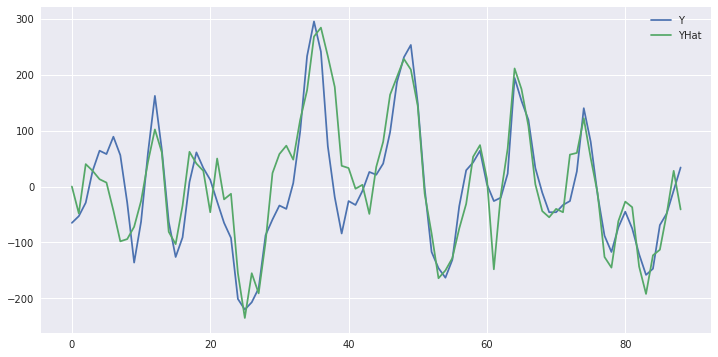

In [108]:
plt.plot(y[:NUM_SAMPLES])
plt.plot(yhat[:NUM_SAMPLES])
plt.legend(["Y", "YHat"])